In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data Exploration & Preprocessing

In [2]:
# get the dataset and prepare it for analysis and model
# set the index to date
df = pd.read_csv('USD_INR.csv')
df['Date'] = pd.to_datetime(df["Date"])
df_idx = df.set_index(["Date"], drop=True)
df_idx.head(5)

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


In [3]:
# flip the dataframe
df_idx = df_idx.sort_index(axis=1, ascending=True)
df_idx = df_idx.iloc[::-1]

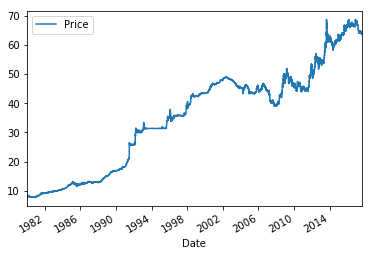

In [4]:
# plot the data
data = df_idx[['Price']]
data.plot(y='Price')

In [5]:
diff = data.index.values[-1] - data.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 1980 to %d"%(1980 + int(0.8*years)))

Total data: 37 years
80 percent data = 1980 to 2009


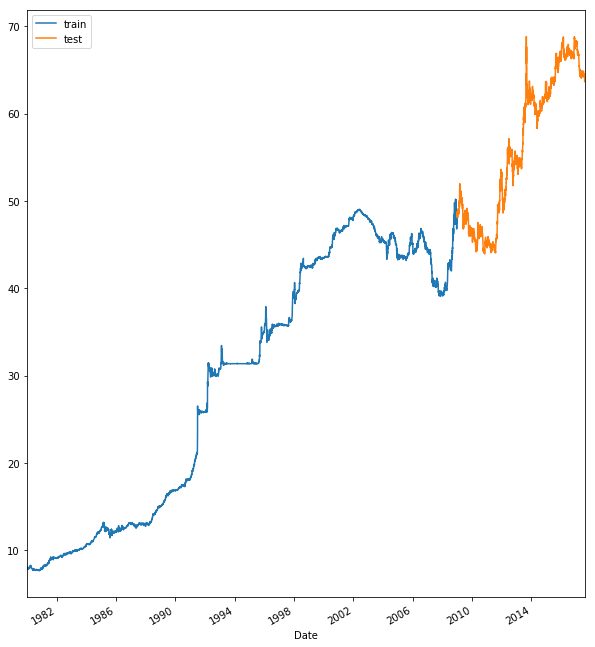

In [6]:
# create training and testing data
split_date = pd.Timestamp('01-01-2009')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

In [7]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [8]:
# review the difference between fit_transform and trasform
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [9]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (7451 x 1)
Test size: (2245 x 1)


# Setup baseline model of SVM Regressor

In [10]:
from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

In [11]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

/Users/iris/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


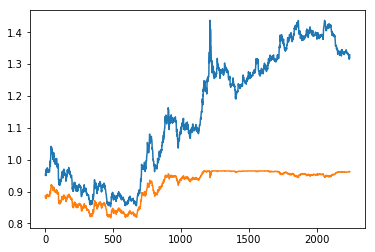

In [12]:
plt.plot(y_test)
plt.plot(y_pred)

In [13]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print(r2_test)

-0.963380530536


# Build a Neural Network

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

Using TensorFlow backend.


1 hidden layer with 1 neuron

In [15]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
7451/7451 [==============================] - 1s 127us/step - loss: 0.0032
Epoch 2/20
7451/7451 [==============================] - 1s 103us/step - loss: 0.0025
Epoch 3/20
7451/7451 [==============================] - 1s 118us/step - loss: 0.0024
Epoch 4/20
7451/7451 [==============================] - 1s 100us/step - loss: 0.0024
Epoch 5/20
7451/7451 [==============================] - 1s 97us/step - loss: 0.0024
Epoch 6/20
7451/7451 [==============================] - 1s 99us/step - loss: 0.0024
Epoch 7/20
7451/7451 [==============================] - 1s 93us/step - loss: 0.0024
Epoch 8/20
7451/7451 [==============================] - 1s 94us/step - loss: 0.0024
Epoch 9/20
7451/7451 [==============================] - 1s 95us/step - loss: 0.0024
Epoch 10/20
7451/7451 [==============================] - 1s 125us/step - loss: 0.0024
Epoch 11/20
7451/7451 [==============================] - 1s 101us/step - loss: 0.0024
Epoch 12/20
7451/7451 [==============================] - 1s 95us/ste

R-Squared: -1.161347


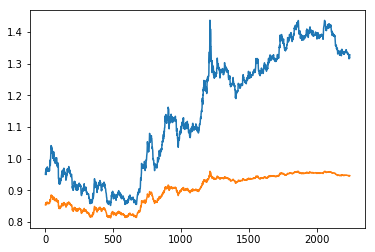

In [16]:
y_pred = model.predict(y_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

1 Hidden Layer with 2 neurons and ReLU activation function

In [17]:
K.clear_session()
model = Sequential()
model.add(Dense(2, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
7451/7451 [==============================] - 1s 168us/step - loss: 9.9865e-06
Epoch 2/20
7451/7451 [==============================] - 1s 121us/step - loss: 8.7703e-06
Epoch 3/20
7451/7451 [==============================] - 1s 120us/step - loss: 8.6619e-06
Epoch 4/20
7451/7451 [==============================] - 1s 129us/step - loss: 8.5463e-06
Epoch 5/20
7451/7451 [==============================] - 1s 144us/step - loss: 8.8738e-06 0s 
Epoch 6/20
7451/7451 [==============================] - 1s 123us/step - loss: 9.2069e-06
Epoch 7/20
7451/7451 [==============================] - 1s 122us/step - loss: 8.6651e-06
Epoch 8/20
7451/7451 [==============================] - 1s 122us/step - loss: 8.6237e-06
Epoch 9/20
7451/7451 [==============================] - 1s 120us/step - loss: 9.2824e-06
Epoch 10/20
7451/7451 [==============================] - 1s 120us/step - loss: 9.0890e-06
Epoch 11/20
7451/7451 [==============================] - 1s 121us/step - loss: 8.6341e-06
Epoch 12/20
745

R-Squared: 0.999997


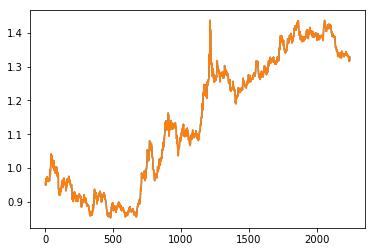

In [18]:
y_pred = model.predict(y_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))